# Setting-up Files

In [ ]:
import pandas as pd

# Read the CSV file
df = pd.read_csv("/content/onedrive/Datasets/IXI/ixi.csv")
df['IXI_ID'] = df.iloc[:, 0].astype(str).str[:3]

# Sort by AGE in descending order of non-NaN values (NaNs go last)
df = df.sort_values(by='AGE', ascending=False, na_position='last')
df = df.drop_duplicates(subset='IXI_ID', keep='first')
df.to_csv("/content/onedrive/Datasets/IXI/IXI_2.csv", index=False)


In [ ]:
len(df['IXI_ID'])

619

# Atlas & Brain Segments

In [ ]:
!pip install -U nilearn
import nibabel as nib
import numpy as np
import pandas as pd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 74.9 MB/s eta 0:00:00


In [ ]:
from nilearn import datasets

atlas_cort = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-1mm')
atlas_sub = datasets.fetch_atlas_harvard_oxford('sub-maxprob-thr25-1mm')
cortical_atlas = atlas_cort.maps.slicer[:]
cortical_labels = atlas_cort.labels
sub_atlas = atlas_sub.maps.slicer[:]
sub_labels = atlas_sub.labels


Added README.md to /root/nilearn_data


Dataset created in /root/nilearn_data/fsl



 ...done. (1 seconds, 0 min)
Extracting data from /root/nilearn_data/fsl/7311eb6e2a75d5a4596a018fd2af9a77/HarvardOxford.tgz..... done.


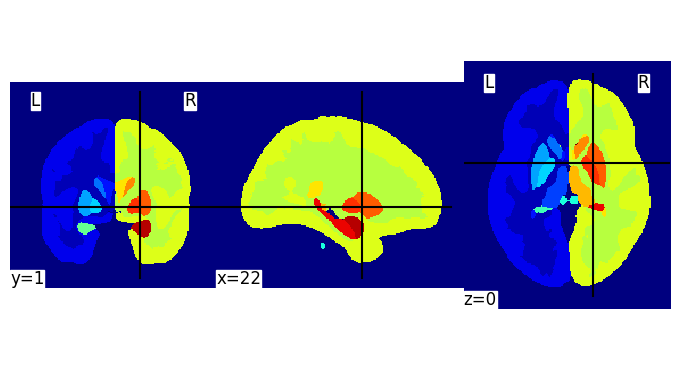

In [ ]:
from nilearn import plotting
plotting.plot_img(sub_atlas, cmap='jet')

1. https://www.sciencedirect.com/topics/immunology-and-microbiology/corpus-striatum#:~:text=The%20corpus%20striatum%20is%20made,twice%20on%20sectioning%20the%20brain.

2. https://radiopaedia.org/articles/corpus-striatum

In [ ]:
pd.DataFrame(sub_labels)

,0
0,Background
1,Left Cerebral White Matter
2,Left Cerebral Cortex
3,Left Lateral Ventricle
4,Left Thalamus
5,Left Caudate
6,Left Putamen
7,Left Pallidum
8,Brain-Stem
9,Left Hippocampus


In [ ]:
pd.DataFrame(cortical_labels)

# Brain Extraction and Registration

In [ ]:
!pip install --upgrade pyrobex antspyx
import os
import nibabel as nib
from pyrobex.robex import robex
from natsort import natsorted
import matplotlib.pyplot as plt
import ants


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 40.2 MB/s eta 0:00:00


In [ ]:
import os
os.makedirs('/content/onedrive/Datasets/IXI/Brain', exist_ok=True)

In [ ]:
def Brain(image, file_name):
    brain_path = f'/content/onedrive/Datasets/IXI/Brain/{file_name}'
    if os.path.exists(brain_path):
      pass
    else:
      img = ants.image_read(image)
      brain, mask = robex(img)
      brain.to_filename(brain_path)
    return brain_path

def Register(brain_path, ref_path):
    brain = ants.image_read(brain_path)
    ref = ants.image_read(ref_path)
    registration = ants.registration(fixed=ref, moving=brain, type_of_transform='Rigid')['warpedmovout']

    return registration


In [ ]:
from tqdm import tqdm
from natsort import natsorted
import pandas as pd

path = '/content/onedrive/Datasets/IXI/T1'
dest = '/content/onedrive/Datasets/IXI/Registered_Rigid'
brain_path = '/content/onedrive/Datasets/IXI/Brain'
df = pd.read_csv('/content/onedrive/Datasets/IXI/IXI_2.csv')
os.makedirs(dest, exist_ok=True)
ref_path = '/content/onedrive/Datasets/Atlas/HarvardOxford-sub-maxprob-thr25-1mm.nii.gz'

files = natsorted(os.listdir(path))

with tqdm(total=len(files), desc="Processing files") as pbar:
    for i in files:
      if i.endswith('.nii.gz'):
          image = os.path.join(path, i)
          output_path = os.path.join(dest, f'reg_{i}')
          if os.path.exists(output_path):
              pbar.update(1)
              continue
          file_id = i[3:6]
          for index, row in df.iterrows():
                  ixi_id = int(str(row['IXI_ID']))
                  if ixi_id == int(file_id):
                    brain = Brain(image, i)
                    reg_brain = Register(brain, ref_path)
                    try:
                      ants.image_write(reg_brain, output_path)
                    finally:
                      if not os.path.exists(output_path):
                        reg_brain.to_filename(output_path)
                    pbar.update(1)
                    break

Processing files:  95%|█████████▍| 551/581 [00:02<00:00, 211.49it/s]


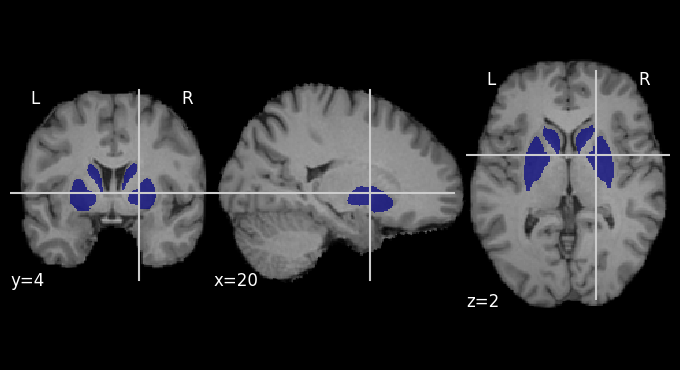

In [ ]:
ref = nib.load('/content/onedrive/Datasets/Atlas/HarvardOxford-sub-maxprob-thr25-1mm.nii.gz')
img = nib.load('/content/onedrive/Datasets/IXI/Registered_affine/reg_IXI002-Guys-0828-T1.nii.gz')
plotting.plot_roi(corpus_straitum, img)

In [ ]:
from tqdm import tqdm
from natsort import natsorted
import pandas as pd
import os

path = '/content/onedrive/Datasets/IXI/T1'
dest = '/content/onedrive/Datasets/IXI/Registered_affine'
brain_path = '/content/onedrive/Datasets/IXI/Brain'
df = pd.read_csv('/content/onedrive/Datasets/IXI/IXI_2.csv')
os.makedirs(dest, exist_ok=True)
ref_path = '/content/onedrive/Datasets/Atlas/HarvardOxford-sub-maxprob-thr25-1mm.nii.gz'

files = natsorted(os.listdir(path))
missing_file_ids = []
with tqdm(total=len(files), desc="Processing files") as pbar:
    for i in files:
        if i.endswith('.nii.gz'):
            image = os.path.join(path, i)
            output_path = os.path.join(dest, f'reg_{i}')
            if os.path.exists(output_path):
                pbar.update(1)
                continue
            file_id = i[3:6]
            matched = False
            for _, row in df.iterrows():
                ixi_id = int(row['IXI_ID'])
                if ixi_id == int(file_id):
                    matched = True
                    brain = Brain(image, i)
                    reg_brain = Register(brain, ref_path)
                    try:
                        ants.image_write(reg_brain, output_path)
                    finally:
                        if not os.path.exists(output_path):
                            reg_brain.to_filename(output_path)
                    pbar.update(1)
                    break
            if not matched:
                missing_file_ids.append(file_id)
                pbar.update(1)
if missing_file_ids:
    print("\nFile IDs not found in CSV:", missing_file_ids)
else:
    print("All file IDs matched entries in the CSV.")


Processing files: 100%|██████████| 581/581 [00:00<00:00, 1133.33it/s]


File IDs not found in CSV: ['637', '638', '643', '661']


In [ ]:
img = nib.load('/content/onedrive/Datasets/IXI/Registered/reg_IXI002-Guys-0828-T1.nii.gz')

In [ ]:
sub_atlas

In [ ]:
from nilearn import plotting

plotting.plot_roi(img, sub_atlas)

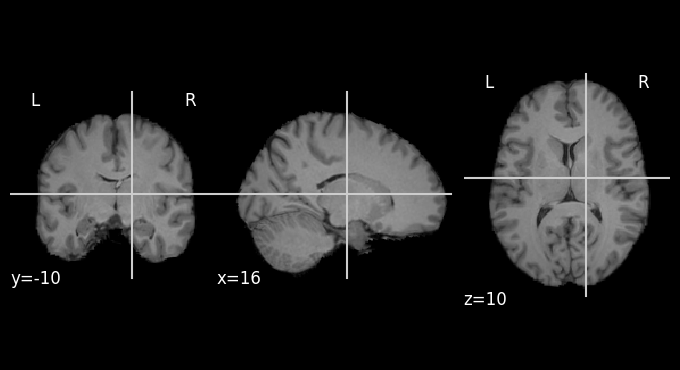

In [ ]:
plotting.plot_anat(img)

# **Calculate Volume**

## Creating Collective masks

In [ ]:

def combined_mask(atlas, region_labels):
    """
    Creates a combined mask from the given atlas for the specified sub-region labels.

    Parameters:
    - atlas (nib.Nifti1Image): NIfTI image of the atlas.
    - region_labels (list): List of region labels to combine.

    Returns:
    - combined_mask_nifti (nib.Nifti1Image): NIfTI image containing the combined mask.
    """
    atlas_data = atlas.get_fdata()

    combined_mask = np.isin(atlas_data, region_labels).astype(np.int8)

    combined_mask_nifti = nib.Nifti1Image(combined_mask, affine=atlas.affine)
    return combined_mask_nifti

amygdala = combined_mask(sub_atlas, [10, 20])
hippocampus = combined_mask(sub_atlas, [9, 19])
corpus_straitum = combined_mask(sub_atlas, [5, 6, 7, 11, 16, 17, 18, 21])



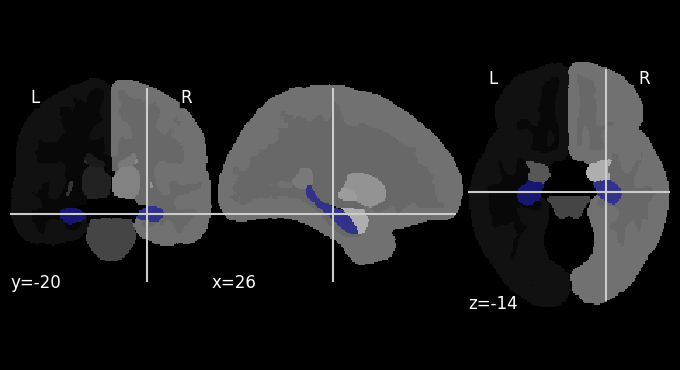

In [ ]:
plotting.plot_roi(hippocampus, sub_atlas)

In [ ]:
os.makedirs('/content/onedrive/Datasets/Atlas/Binary_mask', exist_ok=True)
amygdala.to_filename('/content/onedrive/Datasets/Atlas/Binary_mask/amygdala.nii.gz')
hippocampus.to_filename('/content/onedrive/Datasets/Atlas/Binary_mask/hippocampus.nii.gz')
corpus_straitum.to_filename('/content/onedrive/Datasets/Atlas/Binary_mask/corpus_straitum.nii.gz')

## Volume Estimation

In [ ]:
import pandas as pd
import os
import nibabel as nib
import numpy as np
from tqdm import tqdm
from natsort import natsorted

amygdala = nib.load('/content/onedrive/Datasets/Atlas/Binary_mask/amygdala.nii.gz')
hippocampus = nib.load('/content/onedrive/Datasets/Atlas/Binary_mask/hippocampus.nii.gz')
corpus_straitum = nib.load('/content/onedrive/Datasets/Atlas/Binary_mask/corpus_straitum.nii.gz')

In [ ]:


def calculate_volume(mri_nifti, mask_nifti=None):
    """
    Calculate the volume of the region of interest in the MRI image based on the mask.
    """
    mri_data = mri_nifti.get_fdata()
    voxel_volume = np.prod(mri_nifti.header.get_zooms())

    if mask_nifti is not None:
        mask_data = mask_nifti.get_fdata()
        masked_mri_data = mri_data[mask_data > 0]
        non_zero_voxels = np.sum(masked_mri_data > 0)
    else:
        non_zero_voxels = np.sum(mri_data > 0)

    volume = non_zero_voxels * voxel_volume
    return volume

def calculate_and_append_volumes(csv_file, directory, masks):
    """
    Calculate and append the whole brain and region volumes for MRI images to a CSV file.
    """
    df = pd.read_csv(csv_file)
    df['Whole_Brain_Volume'] = np.nan
    for _, mask_name in masks:
        df[mask_name + '_Volume'] = np.nan
    with tqdm(total=len(os.listdir(directory)), desc="Processing files") as pbar:
      for filename in natsorted(os.listdir(directory)):
          if filename.endswith('.nii.gz'):
              file_id = filename[7:10]
              for index, row in df.iterrows():
                  ixi_id = int(str(row['IXI_ID']))
                  if ixi_id == int(file_id):
                      mri_file_path = os.path.join(directory, filename)
                      mri_nifti = nib.load(mri_file_path)
                      whole_brain_volume = calculate_volume(mri_nifti)
                      df.at[index, 'Whole_Brain_Volume'] = whole_brain_volume
                      for mask_nifti, mask_name in masks:
                          region_volume = calculate_volume(mri_nifti, mask_nifti)
                          df.at[index, mask_name + '_Volume'] = region_volume
                      pbar.update(1)
                      break
    return df

csv_file = "/content/onedrive/Datasets/IXI/IXI_2.csv"
updated_des = "/content/onedrive/Datasets/IXI/Volume_IXI.csv"
mri_directory = "/content/onedrive/Datasets/IXI/Registered_Rigid"
masks = [(amygdala, 'amygdala'), (hippocampus, 'hippocampus'), (corpus_straitum, 'corpus_straitum')]
updated_df = calculate_and_append_volumes(csv_file, mri_directory, masks)


Processing files: 100%|██████████| 551/551 [35:35<00:00,  3.88s/it]


Find Age for cases where age is Nan in case DOB and STUDY_DATE is given.

In [ ]:
updated_df['DOB'] = pd.to_datetime(updated_df['DOB'], errors='coerce')
updated_df['STUDY_DATE'] = pd.to_datetime(updated_df['STUDY_DATE'], errors='coerce')

# Calculate age where AGE is NaN
updated_df['AGE'] = updated_df.apply(
    lambda row: row['AGE'] if pd.notna(row['AGE']) else (row['STUDY_DATE'] - row['DOB']).days / 365.25,
    axis=1
)

Clean dataframe where volumes are missing

In [ ]:
updated_df = updated_df.loc[:, ~updated_df.columns.str.contains('^Unnamed')]
volume_columns = ['Whole_Brain_Volume', 'amygdala_Volume', 'hippocampus_Volume', 'corpus_straitum_Volume', 'AGE']
nan_rows_df = updated_df[updated_df[volume_columns].isna().any(axis=1)]
updated_df = updated_df.dropna(subset=volume_columns)
updated_df.to_csv(updated_des, index=False)

# **Analysis**

In [ ]:
import pandas as pd
updated_df = pd.read_csv("/content/onedrive/Datasets/IXI/Volume_IXI.csv")

In [ ]:
updated_df.head()

,IXI_ID,"SEX_ID (1=m, 2=f)",HEIGHT,WEIGHT,ETHNIC_ID,MARITAL_ID,OCCUPATION_ID,QUALIFICATION_ID,DOB,DATE_AVAILABLE,STUDY_DATE,AGE,Whole_Brain_Volume,amygdala_Volume,hippocampus_Volume,corpus_straitum_Volume
0,430,2,0,0,1,5,5,5,1920-03-31,1,2006-07-26,86.318960,1356761.0,3863.0,7895.0,26543.0
1,605,1,162,75,1,5,5,5,1920-08-22,1,2006-11-03,86.198494,1259675.0,4536.0,8408.0,26543.0
2,577,1,0,960,1,5,5,1,1923-01-14,1,2006-11-06,83.811088,1399849.0,5324.0,10852.0,26543.0
3,163,1,173,0,1,2,5,5,1922-05-05,1,2005-10-19,83.457906,1617858.0,5324.0,11262.0,26543.0
4,465,1,168,62,1,5,5,5,1924-05-20,1,2006-07-28,82.187543,1545802.0,5324.0,11256.0,26543.0


In [ ]:
print(f"Max Age: {updated_df['AGE'].max()} \nMin Age: {updated_df['AGE'].min()}")

Max Age: 86.3189596167009 
Min Age: 19.980835044490075


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr, ttest_ind

In [ ]:
def volume_summary_by_age_gender(df, age_bins):
    """
    Summarizes mean and standard deviation of brain volumes by age groups and gender.

    Parameters:
    - df (pd.DataFrame): DataFrame containing age, gender, and brain volume columns.
    - age_bins (list): List of age intervals for binning, e.g., [0, 30, 40, 50, 60, 100].

    Returns:
    - summary_df (pd.DataFrame): Summary DataFrame with mean and std volume per group.
    """
    df['Age_Group'] = pd.cut(df['AGE'], bins=age_bins)
    summary_df = df.groupby(['Age_Group', 'SEX_ID (1=m, 2=f)'], observed=True).agg(
        Whole_Brain_Volume_Mean=('Whole_Brain_Volume', 'mean'),
        Whole_Brain_Volume_Std=('Whole_Brain_Volume', 'std'),
        Amygdala_Volume_Mean=('amygdala_Volume', 'mean'),
        Amygdala_Volume_Std=('amygdala_Volume', 'std'),
        Hippocampus_Volume_Mean=('hippocampus_Volume', 'mean'),
        Hippocampus_Volume_Std=('hippocampus_Volume', 'std'),
        Corpus_Striatum_Volume_Mean=('corpus_straitum_Volume', 'mean'),
        Corpus_Striatum_Volume_Std=('corpus_straitum_Volume', 'std')
    ).reset_index()
    return summary_df.dropna()


In [ ]:
def create_custom_age_bins(df, fixed_bins):
    """
    Adjust fixed age bins to start from the minimum age and end at the maximum age.

    Parameters:
    - df: DataFrame containing the AGE column.
    - fixed_bins: List of fixed intervals for the bins (e.g., [0, 1, 3, 5, 12, 19, 35, 64, 90]).

    Returns:
    - Adjusted list of bin edges based on the data's min and max age.
    """
    min_age = int(df['AGE'].min())
    max_age = int(df['AGE'].max())

    adjusted_bins = [min_age] + [b for b in fixed_bins if b > min_age and b < max_age] + [max_age]
    return adjusted_bins

fixed_bins = [0, 1, 3, 5, 12, 19, 35, 64, 90]
age_bins = create_custom_age_bins(updated_df, fixed_bins)
volume_summary_by_age_gender(updated_df, age_bins)

,Age_Group,"SEX_ID (1=m, 2=f)",Whole_Brain_Volume_Mean,Whole_Brain_Volume_Std,Amygdala_Volume_Mean,Amygdala_Volume_Std,Hippocampus_Volume_Mean,Hippocampus_Volume_Std,Corpus_Striatum_Volume_Mean,Corpus_Striatum_Volume_Std
0,"(19, 35]",1,1.474647e+06,146760.736927,5220.183099,155.697354,10626.394366,1007.650655,26543.000000,0.000000
1,"(19, 35]",2,1.461482e+06,166280.274267,5151.279412,351.103244,10435.617647,1132.414776,26540.808824,15.942300
2,"(35, 64]",1,1.465017e+06,156270.685191,5173.627273,238.219191,10525.827273,1065.078589,26542.909091,0.684634
3,"(35, 64]",2,1.439804e+06,158168.896462,5165.268456,260.756815,10493.342282,930.552842,26542.791946,1.864589
4,"(64, 86]",1,1.464361e+06,165417.369724,5169.196078,238.502748,10557.058824,907.532686,26542.725490,1.960392
5,"(64, 86]",2,1.422191e+06,162554.307602,5026.729730,542.205524,10234.756757,1233.054319,26536.472973,53.360296


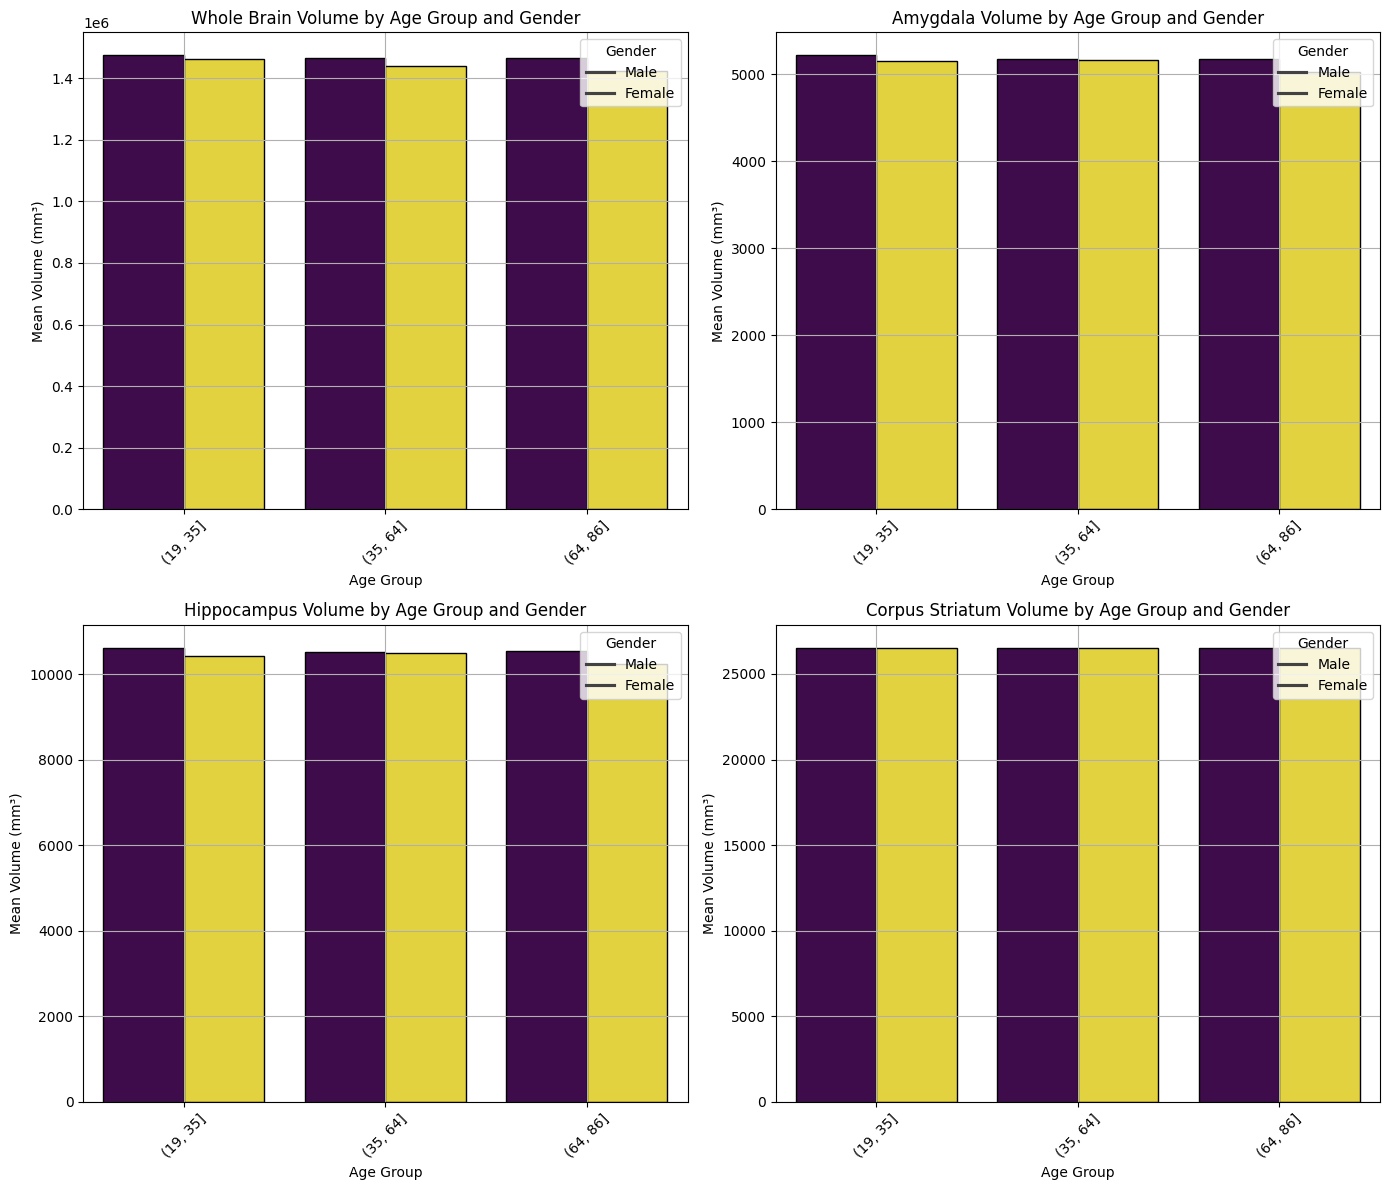

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_volume_summary(summary_df, volume_columns, age_bins):
    """
    Plot volume summaries for multiple brain regions using subplots.

    Parameters:
    - summary_df (pd.DataFrame): DataFrame containing summary statistics.
    - volume_columns (list): List of volume columns to plot.
    - age_bins (list): Age bins used for categorizing the data.
    """
    titles = [col.replace('_Mean', '').replace('_', ' ').title() for col in volume_columns]
    n_rows = (len(volume_columns) + 1) // 2
    n_cols = 2 if len(volume_columns) > 1 else 1

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 6 * n_rows))
    axes = axes.flatten()

    for i, (region, title) in enumerate(zip(volume_columns, titles)):
        ax = axes[i]
        sns.barplot(
            x='Age_Group', y=region, hue='SEX_ID (1=m, 2=f)', data=summary_df,
            errorbar='sd', palette='viridis', edgecolor='black', ax=ax
        )
        ax.set_title(f'{title} by Age Group and Gender')
        ax.set_xlabel('Age Group')
        ax.set_ylabel('Mean Volume (mm³)')
        ax.legend(title='Gender', labels=['Male', 'Female'])
        ax.set_xticks(range(len(summary_df['Age_Group'].unique())))
        ax.set_xticklabels(summary_df['Age_Group'].unique(), rotation=45)

        ax.grid(True)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

summary_df = volume_summary_by_age_gender(updated_df, age_bins)
volume_columns = [col for col in summary_df.columns if 'Volume' in col and 'Mean' in col]
plot_volume_summary(summary_df, volume_columns, age_bins)


In [ ]:
import pandas as pd
from scipy.stats import pearsonr

def volume_age_correlation(df):
    """
    Calculates Pearson correlation between age and brain volumes for each region.

    Parameters:
    - df (pd.DataFrame): DataFrame with age and brain volume columns.

    Returns:
    - correlation_df (pd.DataFrame): DataFrame with correlation coefficients and p-values for each region.
    """
    regions = ['Whole_Brain_Volume', 'amygdala_Volume', 'hippocampus_Volume', 'corpus_straitum_Volume']
    correlation_data = []

    for region in regions:
        corr, p_value = pearsonr(df['AGE'], df[region])
        correlation_data.append({'Region': region, 'Correlation': corr, 'P-Value': p_value})
    correlation_df = pd.DataFrame(correlation_data)
    return correlation_df

correlation_df = volume_age_correlation(updated_df)
correlation_df


,Region,Correlation,P-Value
0,Whole_Brain_Volume,-0.112171,0.010107
1,amygdala_Volume,-0.147661,0.000689
2,hippocampus_Volume,-0.114111,0.008872
3,corpus_straitum_Volume,-0.044384,0.310089


In [ ]:
import pandas as pd
from scipy.stats import ttest_ind

def gender_volume_comparison(df):
    """
    Performs a t-test to compare brain volumes by gender for each region.

    Parameters:
    - df (pd.DataFrame): DataFrame with gender and brain volume columns.

    Returns:
    - comparison_df (pd.DataFrame): DataFrame with t-statistics and p-values for each region.
    """
    regions = ['Whole_Brain_Volume', 'amygdala_Volume', 'hippocampus_Volume', 'corpus_straitum_Volume']
    comparison_data = []

    for region in regions:
        male_volumes = df[df['SEX_ID (1=m, 2=f)'] == 1][region].dropna()
        female_volumes = df[df['SEX_ID (1=m, 2=f)'] == 2][region].dropna()
        t_stat, p_value = ttest_ind(male_volumes, female_volumes)
        comparison_data.append({'Region': region, 'T-Statistic': t_stat, 'P-Value': p_value})

    comparison_df = pd.DataFrame(comparison_data)
    return comparison_df

comparison_df = gender_volume_comparison(updated_df)
comparison_df


,Region,T-Statistic,P-Value
0,Whole_Brain_Volume,1.926967,0.054525
1,amygdala_Volume,2.191991,0.028820
2,hippocampus_Volume,1.613970,0.107137
3,corpus_straitum_Volume,1.182770,0.237438


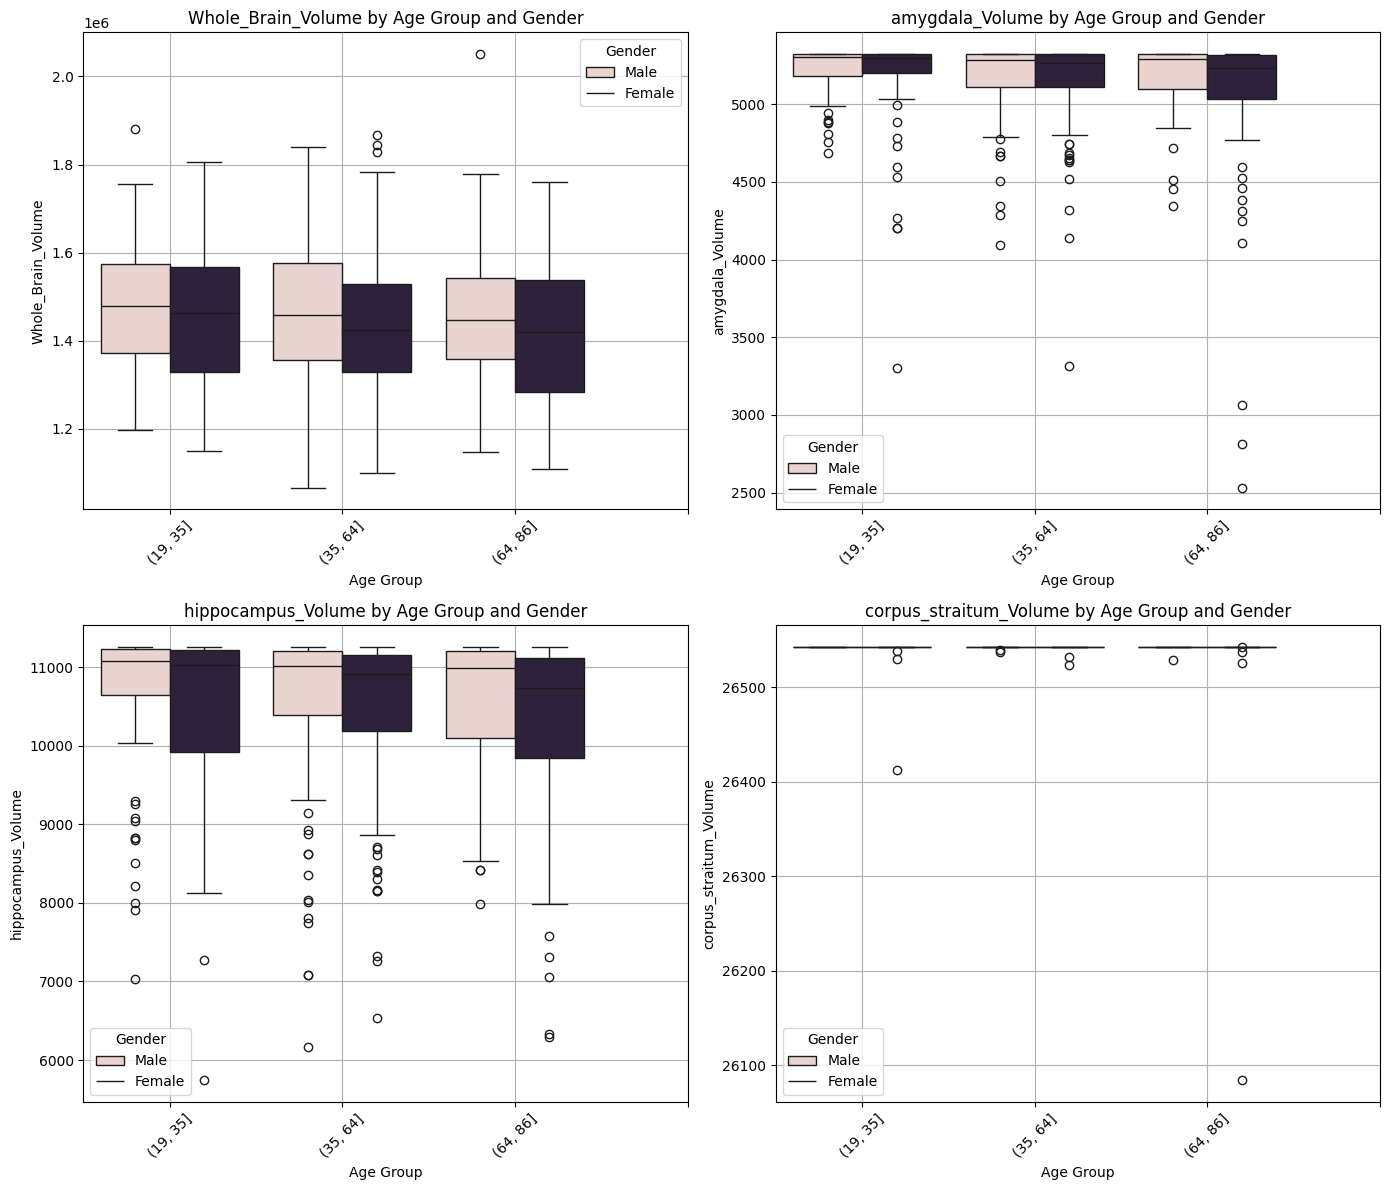

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_boxplot_volume_age_gender(df, volume_columns, age_bins):
    """
    Plots boxplots for multiple brain regions by age group and gender in subplots.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the data.
    - volume_columns (list): List of brain volume columns to plot.
    - age_bins (list): List of age bins for categorizing the data.
    """

    df['Age_Group'] = pd.cut(df['AGE'], bins=age_bins)
    n_rows = (len(volume_columns) + 1) // 2
    n_cols = 2 if len(volume_columns) > 1 else 1
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 6 * n_rows))
    axes = axes.flatten()

    for i, volume_column in enumerate(volume_columns):
        ax = axes[i]
        sns.boxplot(x='Age_Group', y=volume_column, hue='SEX_ID (1=m, 2=f)', data=df, ax=ax)
        ax.set_title(f'{volume_column} by Age Group and Gender')
        ax.set_xlabel('Age Group')
        ax.set_ylabel(f'{volume_column}')
        ax.legend(title='Gender', labels=['Male', 'Female'])
        ax.set_xticks(range(len(df['Age_Group'].unique())))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.grid(True)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

volume_columns = [col for col in updated_df.columns if 'Volume' in col]
plot_boxplot_volume_age_gender(updated_df, volume_columns, age_bins)


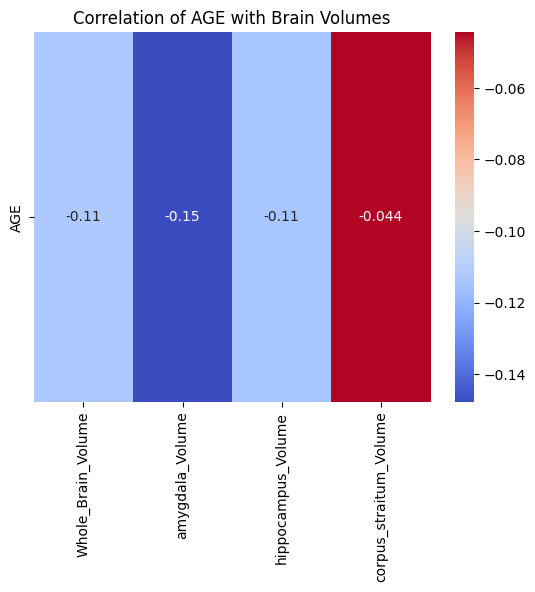

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_age_correlation_heatmap(df):
    correlation_matrix = df[['AGE', 'Whole_Brain_Volume', 'amygdala_Volume',
                             'hippocampus_Volume', 'corpus_straitum_Volume']].corr()

    age_correlation = correlation_matrix.loc[['AGE'], ['Whole_Brain_Volume',
                                                       'amygdala_Volume',
                                                       'hippocampus_Volume',
                                                       'corpus_straitum_Volume']]

    sns.heatmap(age_correlation, annot=True, cmap='coolwarm', cbar=True)
    plt.title('Correlation of AGE with Brain Volumes')
    plt.show()
plot_age_correlation_heatmap(updated_df)


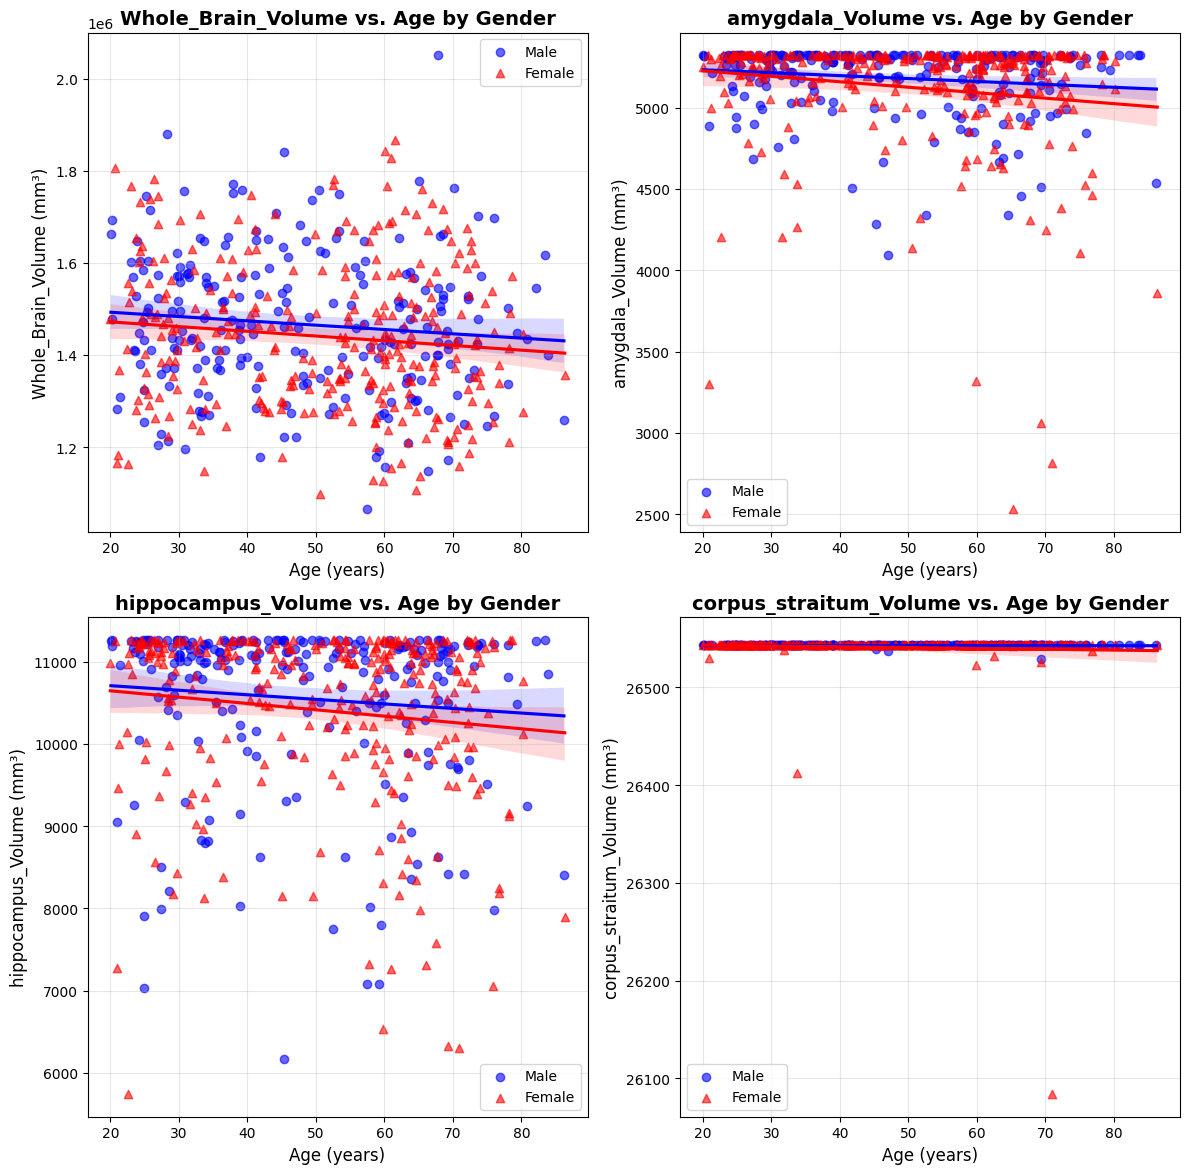

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_volume_vs_age(df):
    volume_columns = [col for col in df.columns if 'Volume' in col]
    n_cols = 2
    n_rows = (len(volume_columns) + 1) // n_cols

    plt.figure(figsize=(12, n_rows * 6))

    for i, region in enumerate(volume_columns):
        ax = plt.subplot(n_rows, n_cols, i + 1)

        male_data = df[df['SEX_ID (1=m, 2=f)'] == 1]
        female_data = df[df['SEX_ID (1=m, 2=f)'] == 2]

        ax.scatter(male_data['AGE'], male_data[region],
                   color='blue', alpha=0.6, label='Male', marker='o')
        ax.scatter(female_data['AGE'], female_data[region],
                   color='red', alpha=0.6, label='Female', marker='^')

        sns.regplot(x='AGE', y=region, data=male_data, scatter=False,
                    color='blue', line_kws={'label': 'Male Trend'}, ax=ax)
        sns.regplot(x='AGE', y=region, data=female_data, scatter=False,
                    color='red', line_kws={'label': 'Female Trend'}, ax=ax)

        ax.set_title(f'{region} vs. Age by Gender', fontsize=14, fontweight='bold')
        ax.set_xlabel('Age (years)', fontsize=12)
        ax.set_ylabel(f'{region} (mm³)', fontsize=12)
        ax.legend(fontsize=10)
        ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_volume_vs_age(updated_df)


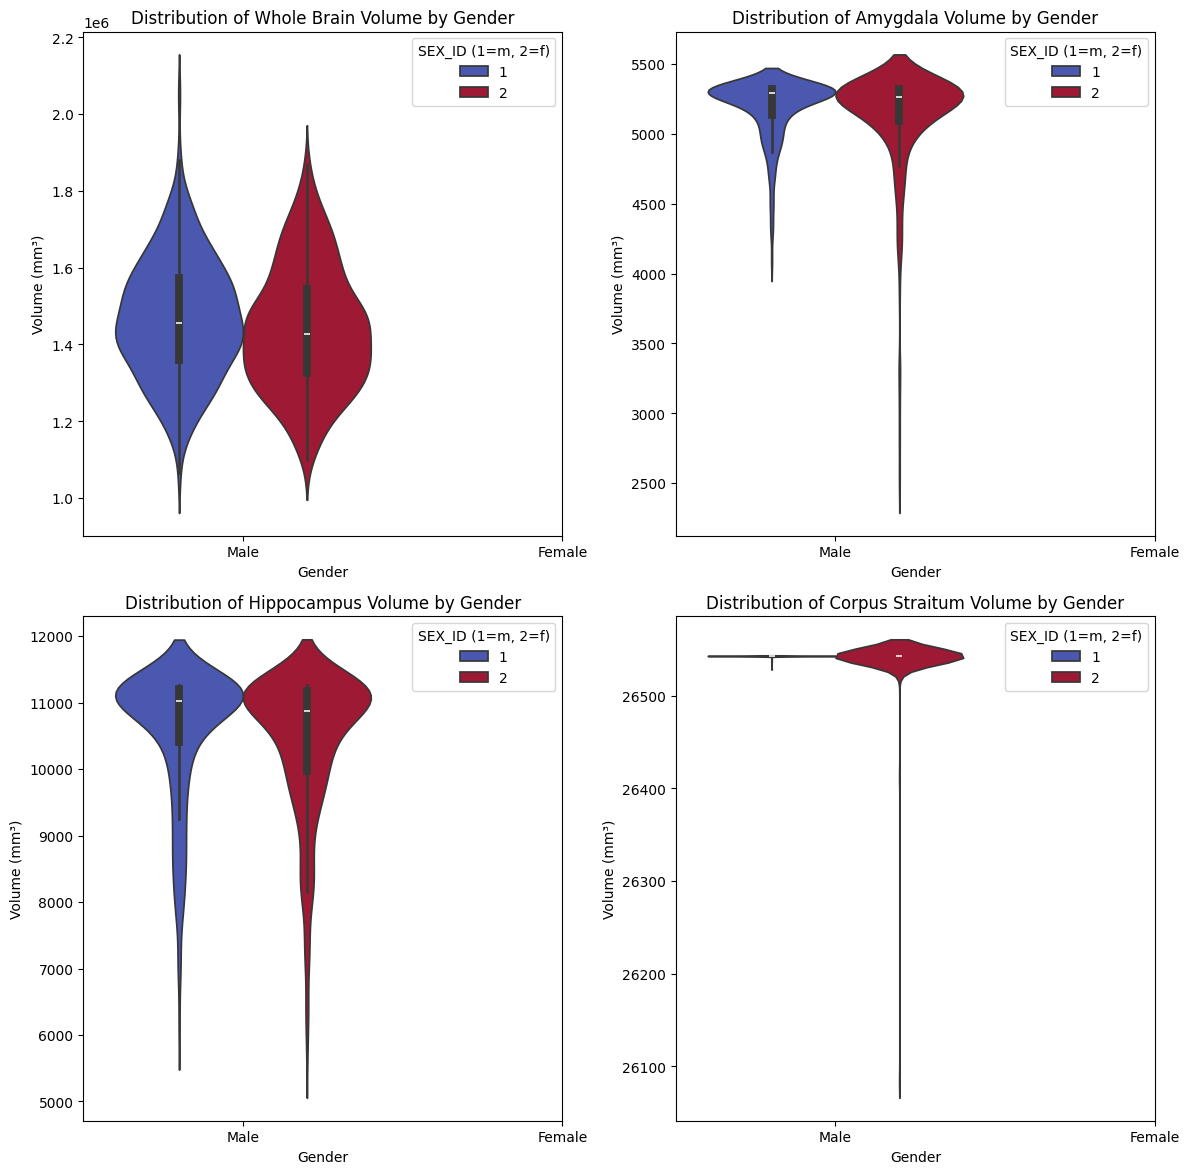

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_violin_volume_by_gender(df):
    brain_regions = [col for col in df.columns if 'Volume' in col]
    titles = [col.replace('_', ' ').title() for col in brain_regions]
    num_regions = len(brain_regions)
    rows = (num_regions + 1) // 2
    cols = 2

    fig, axes = plt.subplots(rows, cols, figsize=(12, 6 * rows))
    axes = axes.flatten()

    for i, region in enumerate(brain_regions):
        sns.violinplot(ax=axes[i], hue='SEX_ID (1=m, 2=f)', y=region, data=df, palette='coolwarm')
        axes[i].set_title(f'Distribution of {titles[i]} by Gender')
        axes[i].set_xlabel('Gender')
        axes[i].set_ylabel('Volume (mm³)')
        axes[i].set_xticks([0, 1])
        axes[i].set_xticklabels(['Male', 'Female'])

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()

plot_violin_volume_by_gender(updated_df)
